# Обучение классификатора

In [ ]:
# проверяем наличие подключенной видеокарты
!nvidia-smi

Sun May 14 17:45:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Импорт библиотек

In [ ]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time

<ipython-input-2-5ee73a141a22>:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Загрузка датасета

In [ ]:
!unzip Dataset_9_Classes.zip

Archive:  Dataset_9_Classes.zip
   creating: Dataset_9_Classes/
   creating: Dataset_9_Classes/test/
   creating: Dataset_9_Classes/test/arabic/
 extracting: Dataset_9_Classes/test/arabic/24dca116894a4de7e530f7f7ffdf5cea--islamic-images-arabic-beauty.jpg  
 extracting: Dataset_9_Classes/test/arabic/a31224b.jpg  
 extracting: Dataset_9_Classes/test/arabic/Calligraphy-Arabic-Font161-min.jpg  
 extracting: Dataset_9_Classes/test/arabic/epigraphy_ambalangoda_port_des_01.jpg  
 extracting: Dataset_9_Classes/test/arabic/istockphoto-183578917-612x612.jpg  
 extracting: Dataset_9_Classes/test/arabic/istockphoto-644911038-1024x1024.jpg  
 extracting: Dataset_9_Classes/test/arabic/Khirbet-Inscription-Hisham.jpg  
 extracting: Dataset_9_Classes/test/arabic/MalDia-04-10-08-16-Abate-Vella-claimed-to-have-discovered-ancient-Arabic-parchments.-751x1024.jpg  
 extracting: Dataset_9_Classes/test/arabic/Writing-style-follow-by-Arabic-Script_Q320.jpg  
   creating: Dataset_9_Classes/test/egyptian/
 extra

Аугментация данных и нормализация под ImageNet (НЕ БРАЛИ test)

In [ ]:
# Для валидационной (тестовой) выборки только нормализация

from torchvision import transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),                                 # аугментация: случайно обрезаем изображение до [244 х 244]
        transforms.ColorJitter(brightness=0.5),                            # аугментация: изменение цвета
        transforms.RandomRotation(degrees=25),                             # аугментация: случайный поворот
        transforms.RandomHorizontalFlip(),                                 # аугментация: с вероятностью 0.5 отражаем картинку по горизонтали
        transforms.RandomGrayscale(p=0.4),                                 # аугментация: черно-белое изображений
        transforms.ToTensor(),                                             # преобразование к типу torch.tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # нормализация под ImageNet
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),                                            # преобразование размера изображения
        transforms.CenterCrop(244),                                        # обрезка по центру
        transforms.ToTensor(),                                             # преобразование к типу torch.tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # нормализация под ImageNet
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),                                            # преобразование размера изображения
        transforms.CenterCrop(244),                                        # обрезка по центру
        transforms.ToTensor(),                                             # преобразование к типу torch.tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # нормализация под ImageNet
    ]),
}


# папка с датасетом
data_dir = './Dataset_9_Classes'

from torchvision import datasets

image_datasets = {}                                                                       # словарь для каждой папки создается объект datasets.ImageFolder()
for folder in ['train', 'valid', 'test']:
  path_to_folder = os.path.join(data_dir, folder)                                         # формирование полного пути до папок train, test
  print("path to", folder,":", path_to_folder)
  image_datasets[folder] = datasets.ImageFolder(path_to_folder, data_transforms[folder])  # указываем путь и преобразования
 

# специальный класс для загрузки данных в виде батчей
dataloaders = {}
for folder in ['train', 'valid', 'test']:             #          ImageFolder        размер батча   перемешать    параллельно
  dataloaders[folder] = torch.utils.data.DataLoader(image_datasets[folder], batch_size=4, shuffle=True, num_workers=2)


# размеры датасетов
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
# названия классов
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

path to train : ./Dataset_9_Classes/train
path to valid : ./Dataset_9_Classes/valid
path to test : ./Dataset_9_Classes/test


Размеры обучающей и валидационной выборок:

In [ ]:
print(dataset_sizes)

{'train': 285, 'valid': 74, 'test': 92}


Названия классов

In [ ]:
print(class_names)

['arabic', 'egyptian', 'latin', 'mycenaean greek', 'old_chinese', 'sanskrit', 'sl', 'sumerian', 'tamil']


Посмотрим на картинки одного батча (4 штуки)

inputs.shape= torch.Size([4, 3, 244, 244]) 
classes.shape= torch.Size([4])


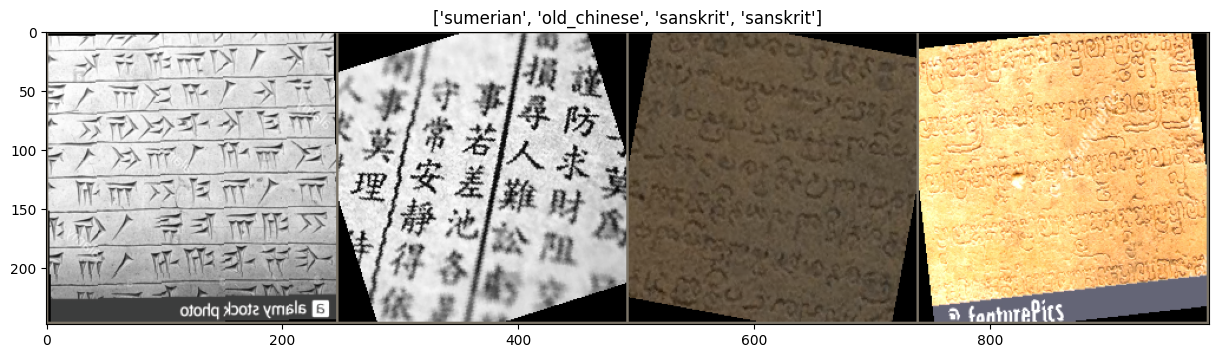

In [ ]:
# функция для отображения картинок (train)
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картинки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))
print("inputs.shape=", inputs.shape, "\nclasses.shape=", classes.shape)

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

inputs.shape= torch.Size([4, 3, 244, 244]) 
classes.shape= torch.Size([4])


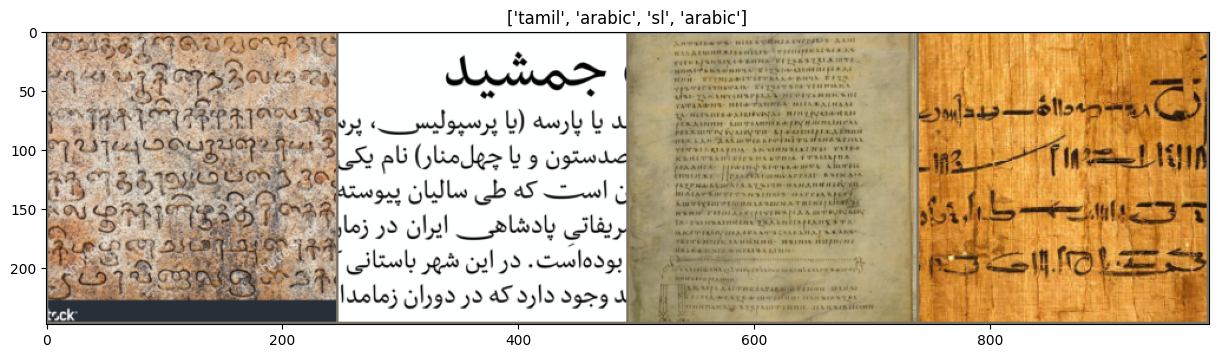

In [ ]:
# Получим 1 батч (картинки-метки) из валидационной выборки
inputs, classes = next(iter(dataloaders['valid']))
print("inputs.shape=", inputs.shape, "\nclasses.shape=", classes.shape)

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

inputs.shape= torch.Size([4, 3, 244, 244]) 
classes.shape= torch.Size([4])


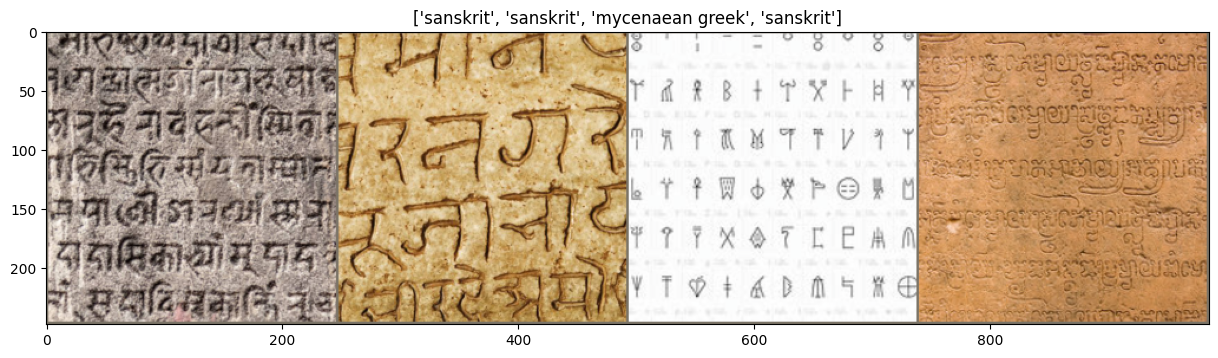

In [ ]:
# Получим 1 батч (картнки-метки) из тестовой выборки
inputs, classes = next(iter(dataloaders['test']))
print("inputs.shape=", inputs.shape, "\nclasses.shape=", classes.shape)

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Следующая функция будет использоваться для обучения модели. Аргументы:  
* model $-$ нейросеть
* criterion (loss) $-$ оптимизируемая функция (criterion, cost function, objective)
* optimizer $-$ оптимизационный алгоритм
* scheduler $-$ политика изменения learning_rate
* num_epochs $-$ количество итераций обучения

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()                                                                  # запоминаем текущее время, чтобы посчитать длительность
                                                                                         # обучения по всем эпохам
    best_model_wts = model.state_dict()                                                  # сюда запишем лучшие веса модели
    best_acc = 0.0                                                                       # лучшее достигнутое значение точности на эпохе
    
    #Ваш код здесь
    losses = {'train': [], "valid": []}                                                  # запоминаем изменение функции потерь

    pbar = trange(num_epochs, desc="Epoch:")                                             # отслеживание прогресс по эпохам

    for epoch in pbar:                                                               # итерируемся по эпохам                                                                               
        for phase in ['train', 'valid']:                                               # в зависимости от стадии меняем режим работы
            if phase == 'train':
                scheduler.step()                                                       # на каждой эпохе изменяем градиент (уменьшаем)
                model.train(True)                                                      # установить модель в режим обучения
            else:
                model.eval()                                                           # установить модель в режим инференса

            running_loss = 0.0                                                         # сюда будем сохранять значение функции потерь по одному батчу
            running_corrects = 0                                                       # сюда будем сохранять долю правильно угаданных объектов в одном батче

            
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):    # итерируемся по батчам
                
                inputs, labels = data                                                    # получаем картинки и метки

               
                if use_gpu:                                                              # если есть карта, вычисляем на ней 
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels                                      # иначе ничего не делаем

                
                if phase=="train":                                                       # этап обучения
                    optimizer.zero_grad()                                                # на каждом новом батче обнуляем градиенты

                # forward pass
                if phase == "valid":                                                     # этап валидации,
                    with torch.no_grad():                                                # отключаем подсчет градиентов, ускоряем вычисления
                        outputs = model(inputs)                                          # вычисляем выходные значения (не факт, что вероятности)
                else:
                    outputs = model(inputs)                                              # этап обучения, получили выходные значения (-//-)
                preds = torch.argmax(outputs, -1)                                        # индекс наибольшего значения == класс текущего объекта (4)
                loss = criterion(outputs, labels)                                        # считаем функцию потерь, переданную как аргумент

                if phase == 'train':                                                     # этап обучения
                    loss.backward()                                                      # обратное распространение
                    optimizer.step()                                                     # обновление весов модели

                                                                                         # статистика на тренировке
                running_loss += loss.item()                                              # после каждого батча считается средняя функция потерь
                running_corrects += int(torch.sum(preds == labels.data))                 # после каждого батча считается доля правильно угаданных объектов

            epoch_loss = running_loss / dataset_sizes[phase]                           # когда одна эпоха завершена считаем функцию потерь и accuracy
            epoch_acc = running_corrects / dataset_sizes[phase]                        # усредненные по всем батчам в эпохе (по всему количеству объектов)
            
    
            losses[phase].append(epoch_loss)                                           # значения записываем в список со статистикой
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            
            if phase == 'valid' and epoch_acc > best_acc:                              # если достигнуто лучшее качество на валидации, то 
                best_acc = epoch_acc                                                   # запомним значение точности
                best_model_wts = model.state_dict()                                    # и запомним веса модели

    time_elapsed = time.time() - since                                              # сколько времени заняло обучение по всем эпохам
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    model.load_state_dict(best_model_wts)                                           # загрузим лучшие веса модели с валидации 
    return model, losses

* Функция для отрисовки валидационных изображений и предсказаний для них:

In [ ]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['valid']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

* Функция для измерения точности модели на валидационном датасете

In [ ]:
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['valid']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['valid']

Функция для измерения точности модели на тестовом датасете

In [ ]:
def evaluate_test(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['test']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forward pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['test']

In [ ]:
def test_one_picture(model):
    model.eval()
    for data in dataloaders['test']:
        # получаем картинки и метки
        
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        break;
    output = model(inputs)
    _, predicted = torch.max(output, 1)
    return inputs, output, predicted

функция для отображения графика функции потерь и вычисления точности

In [ ]:
def plot_graph_show_acc(losses, model):
  import seaborn as sns

  sns.set(style="whitegrid", font_scale=1.4)

  # Построим график лосса при обучении и валидации

  #Ваш код здесь
  plt.figure(figsize=(12, 8))
  plt.plot(losses['train'], label="train")
  plt.plot(losses['valid'], label="valid")
  plt.legend()
  plt.show()

  print("Accuracy: {0:.4f}".format(evaluate(model)))

функция для вычисления точности на тестовой выборке

In [ ]:
def show_test_acc(model):
  print("Accuracy: {0:.4f}".format(evaluate_test(model)))

## **Обучение AlexNet**

<img src="https://www.learnopencv.com/wp-content/uploads/2018/05/AlexNet-1.png">

Загрузка модели:

In [ ]:
from torchvision import models

model = models.alexnet(pretrained=True)  # подключаем веса ImageNet'а

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:15<00:00, 16.2MB/s]


Посмотрим, что внутри (сколько нейронов на вход классификатору):

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

* **Без заморозки весов, всю сеть, свой классификатор (Fine Tuning)** способ

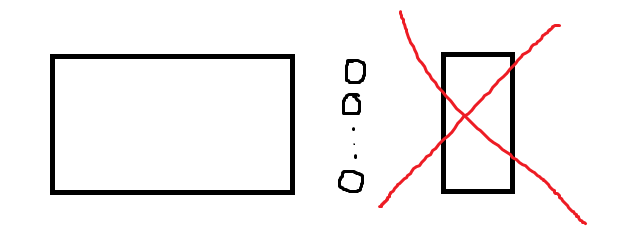

Сконфигурируем - изменим FC-слой и зададим *cost function* и *оптимизирующий алгоритм*:

(*по умолчанию backpropagation распространяется на все слои, поэтому здесь мы только заменяем FC-слой на свой классификатор*)

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - Adam
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 30 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

In [ ]:
# наша сеть
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=9, bias=True)
)

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in model.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 2552649


In [ ]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

Training complete in 1m 14s
Best val Acc: 0.675676


Нарисуем график функции потерь и вычислим точность

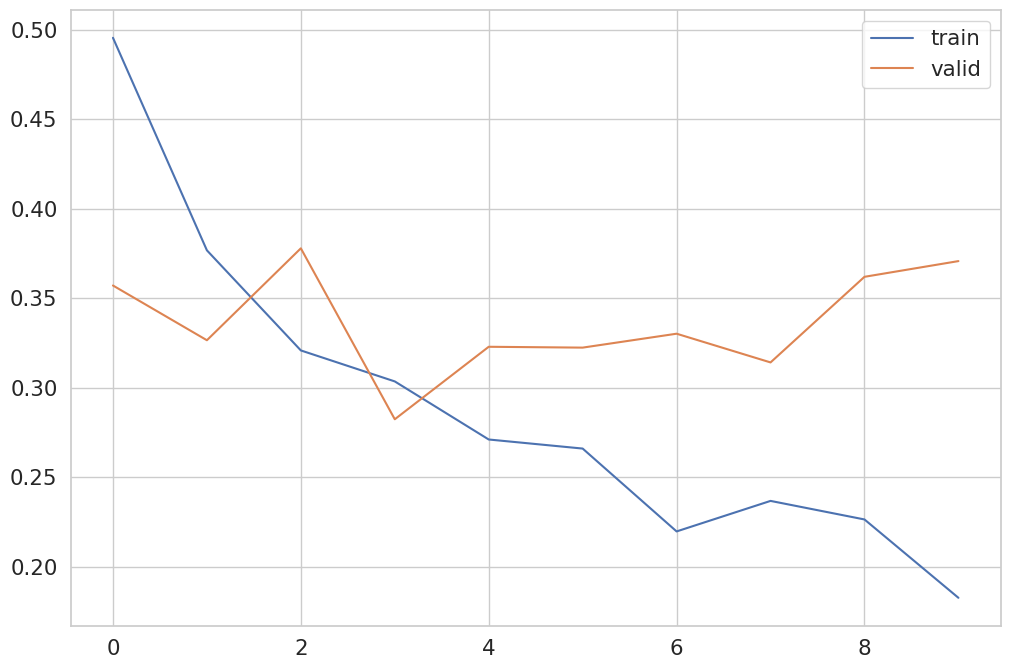

Accuracy: 0.5946


In [ ]:
plot_graph_show_acc(losses, model)

In [ ]:
show_test_acc(model)

Accuracy: 0.6739


* **С заморозкой  1/3 FE, свой классификатор (Feature Extractor)** способ:

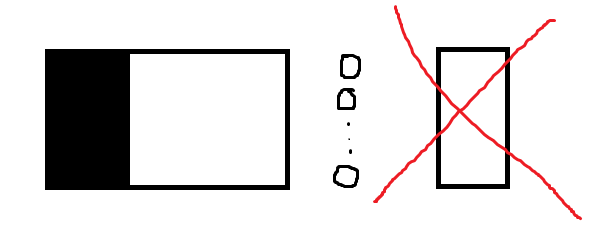

In [ ]:
model_extractor_1 = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Сделаем так, чтобы на них *не распространялся backpropagation* (заморозим их), и подменим классификатор (ведь старый уже с весами для ImageNet'а).

In [ ]:
# замораживаем параметры (веса)
for param in model_extractor_1.features[:2+1].parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor_1.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    model_extractor_1 = model_extractor_1.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только незамороженные слои
optimizer = optim.Adam(list(model_extractor_1.features.parameters())[2+1:] + 
                       list(model_extractor_1.classifier.parameters()), lr=1e-4)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
model_extractor_1

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=9, bias=True)
)

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in model_extractor_1.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 2529353


In [ ]:
%%time
model_extractor_1,losses = train_model(model_extractor_1, loss_fn, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

Training complete in 1m 7s
Best val Acc: 0.702703
CPU times: user 9.27 s, sys: 2.61 s, total: 11.9 s
Wall time: 1min 6s


Нарисуем график функции потерь и вычислим точность

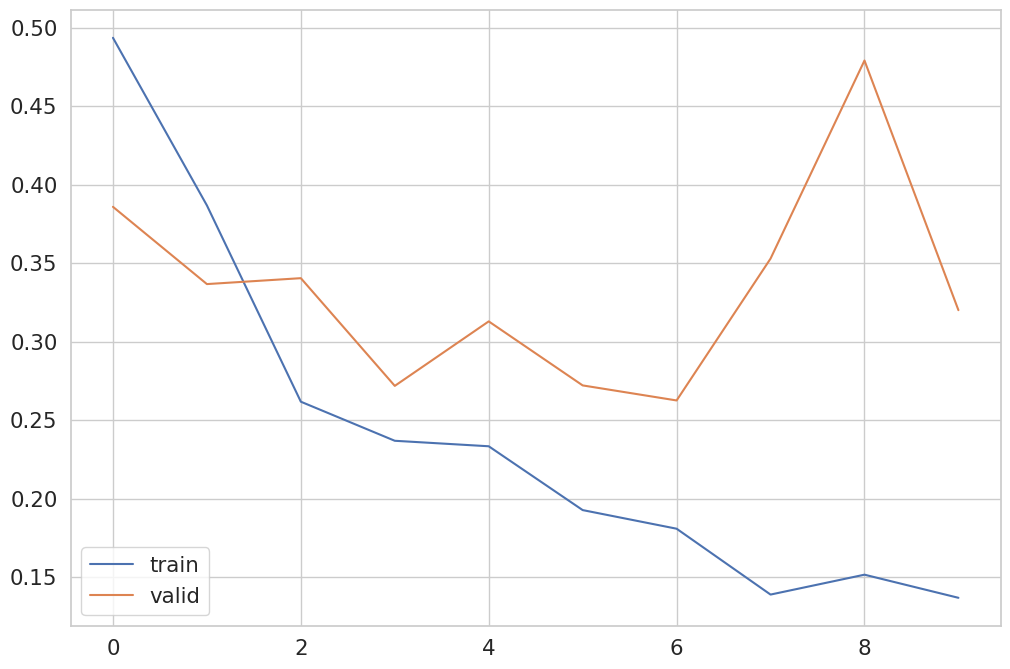

Accuracy: 0.7027


In [ ]:
plot_graph_show_acc(losses, model_extractor_1)

In [ ]:
show_test_acc(model_extractor_1)

Accuracy: 0.6957


* **С заморозкой  2/3 FE, свой классификатор (Feature Extractor)** способ:

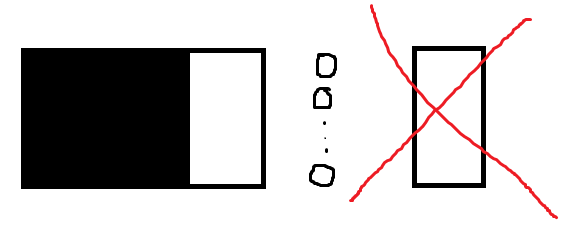

In [ ]:
model_extractor_2 = models.alexnet(pretrained=True)

In [ ]:
model_extractor_2

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# замораживаем параметры (веса)
for param in model_extractor_2.features[:7+1].parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor_2.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    model_extractor_2 = model_extractor_2.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только незамороженные слои
optimizer = optim.Adam(list(model_extractor_2.features.parameters())[7+1:] + 
                       list(model_extractor_2.classifier.parameters()), lr=1e-4)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
model_extractor_2

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=9, bias=True)
)

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in model_extractor_2.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 1558025


In [ ]:
%%time
model_extractor_2, losses = train_model(model_extractor_2, loss_fn, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

Training complete in 1m 5s
Best val Acc: 0.689189
CPU times: user 7.38 s, sys: 2.59 s, total: 9.97 s
Wall time: 1min 5s


Нарисуем график функции потерь и вычислим точность

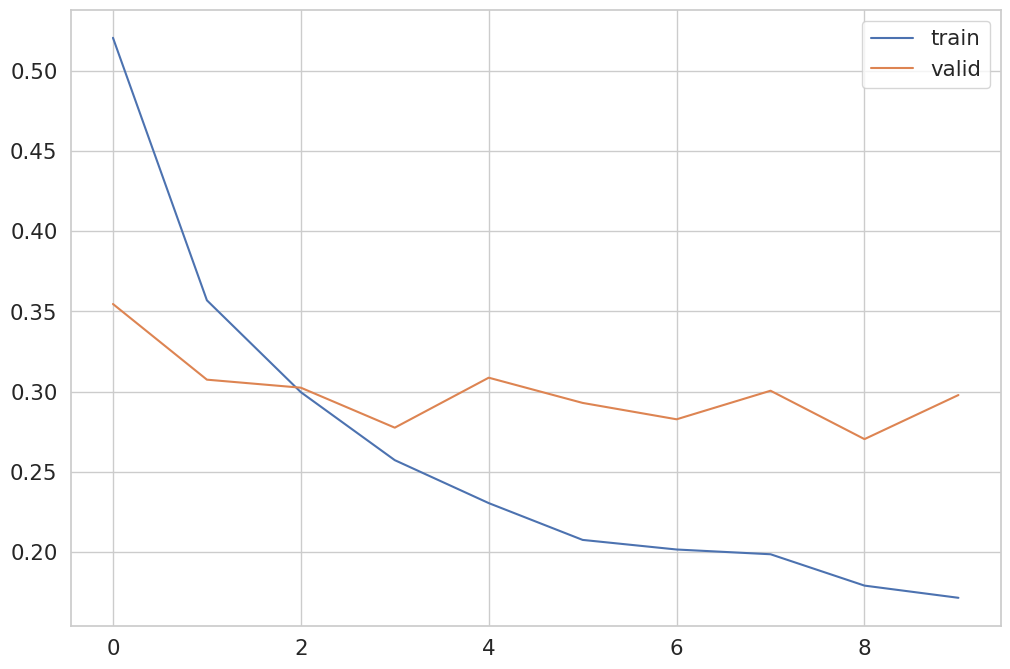

Accuracy: 0.6892


In [ ]:
plot_graph_show_acc(losses, model_extractor_2)

In [ ]:
show_test_acc(model_extractor_2)

Accuracy: 0.6630


* **С заморозкой  3/3 FE, свой классификатор (Feature Extractor)** способ:

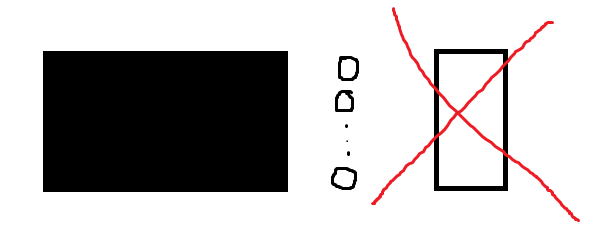

In [ ]:
model_extractor_3 = models.alexnet(pretrained=True)

сначала замораживаем Feature Extractor и обучаем только Head...

In [ ]:
# замораживаем параметры (веса)
for param in model_extractor_3.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor_3.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    model_extractor_3 = model_extractor_3.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.Adam(model_extractor_3.classifier.parameters(), lr=1e-4)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in model_extractor_3.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 82953


In [ ]:
%%time
model_extractor_3,losses = train_model(model_extractor_3, loss_fn, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

Training complete in 1m 5s
Best val Acc: 0.635135
CPU times: user 6.36 s, sys: 2.49 s, total: 8.85 s
Wall time: 1min 4s


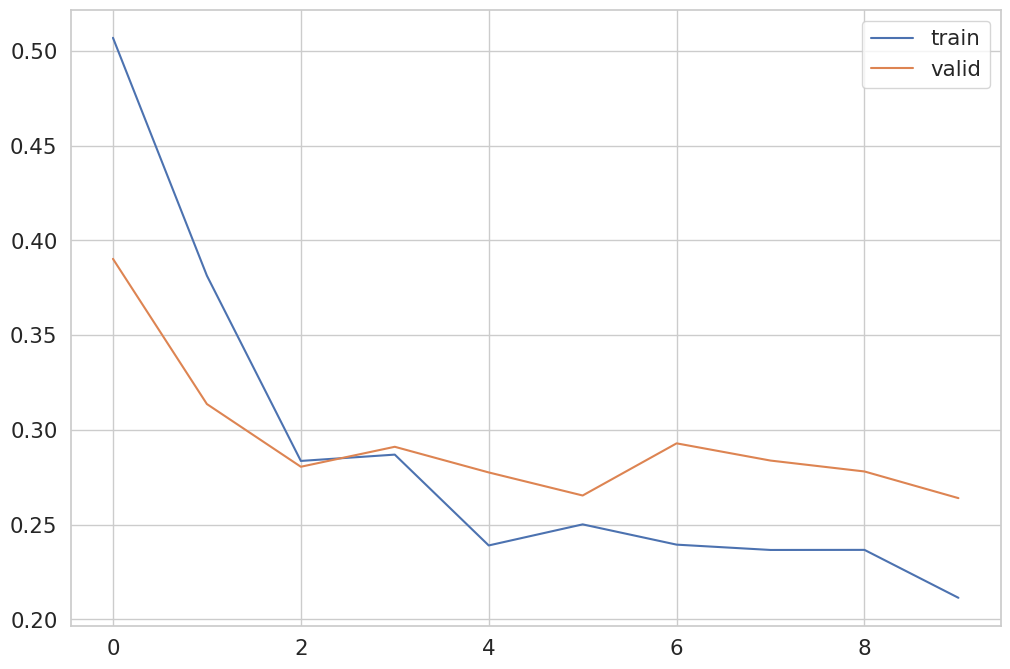

Accuracy: 0.6351


In [ ]:
plot_graph_show_acc(losses, model_extractor_3)

In [ ]:
show_test_acc(model_extractor_3)

Accuracy: 0.6522


# VGG-16

<img src="https://cdn-images-1.medium.com/max/1040/1*0Tk4JclhGOCR_uLe6RKvUQ.png">


In [ ]:
from torchvision import models
model_VGG = models.vgg16(pretrained=True)
model_VGG

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:34<00:00, 16.2MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

* **Без заморозки весов, всю сеть, свой классификатор (Fine Tuning)** способ

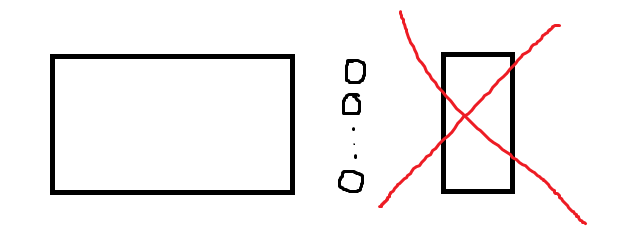

Сконфигурируем - изменим FC-слой и зададим *cost function* и *оптимизирующий алгоритм*:

(*по умолчанию backpropagation распространяется на все слои, поэтому здесь мы только заменяем FC-слой на свой классификатор*)

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_VGG.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    model_VGG = model_VGG.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - Adam
optimizer_ft = optim.Adam(model_VGG.parameters(), lr=1e-4)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
# наша сеть
model_VGG

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in model_VGG.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 14940489


In [ ]:
model_VGG, losses = train_model(model_VGG, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=15)

Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

Training complete in 2m 19s
Best val Acc: 0.837838


Нарисуем график функции потерь и вычислим точность

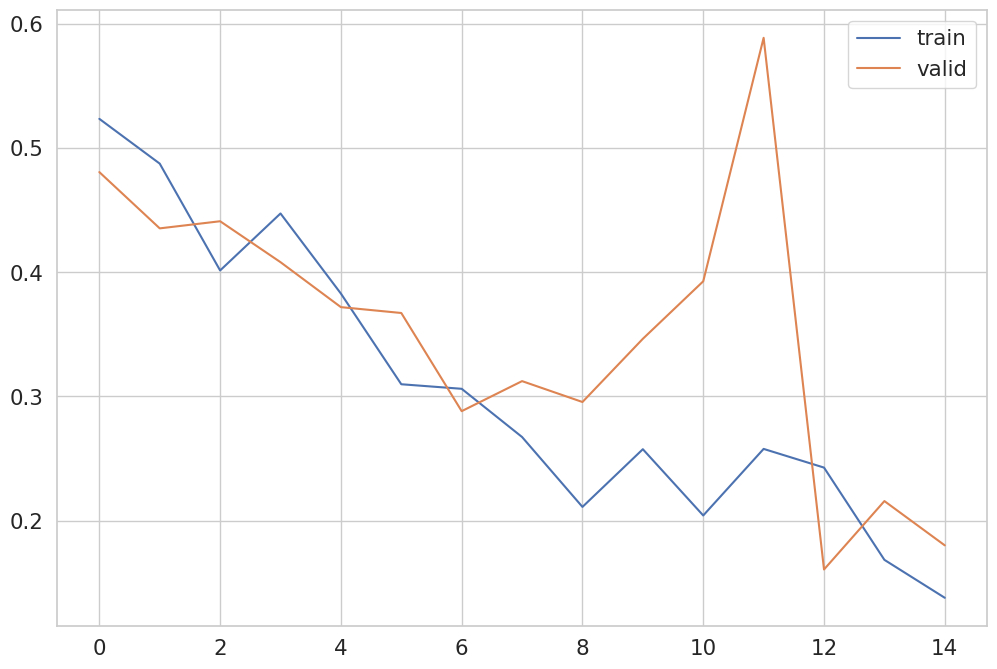

Accuracy: 0.7432


In [ ]:
plot_graph_show_acc(losses, model_VGG)

In [ ]:
show_test_acc(model_VGG)

Accuracy: 0.7826


* **С заморозкой  1/3 FE, свой классификатор (Feature Extractor)** способ:

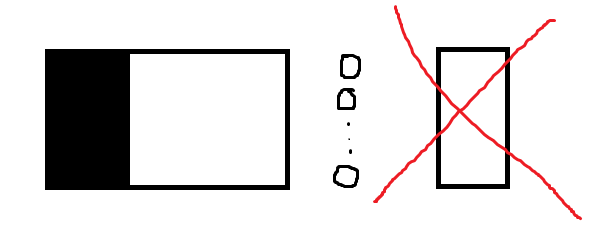

In [ ]:
model_VGG_extractor_1 = models.vgg16(pretrained=True)

Сделаем так, чтобы на них *не распространялся backpropagation* (заморозим их), и подменим классификатор (ведь старый уже с весами для ImageNet'а).

In [ ]:
# замораживаем параметры (веса)
for param in model_VGG_extractor_1.features[:16+1].parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_VGG_extractor_1.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    model_VGG_extractor_1 = model_VGG_extractor_1.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только незамороженные слои
optimizer = optim.Adam(list(model_VGG_extractor_1.features.parameters())[16+1:] + 
                       list(model_VGG_extractor_1.classifier.parameters()), lr=1e-4)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
for param in model_VGG_extractor_1.parameters():
  print(int(param.requires_grad), end = ' ')

0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
model_VGG_extractor_1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in model_VGG_extractor_1.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 13205001


In [ ]:
%%time
model_VGG_extractor_1,losses = train_model(model_VGG_extractor_1, loss_fn, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

Training complete in 1m 57s
Best val Acc: 0.797297
CPU times: user 42.2 s, sys: 4.07 s, total: 46.3 s
Wall time: 1min 56s


Нарисуем график функции потерь и вычислим точность

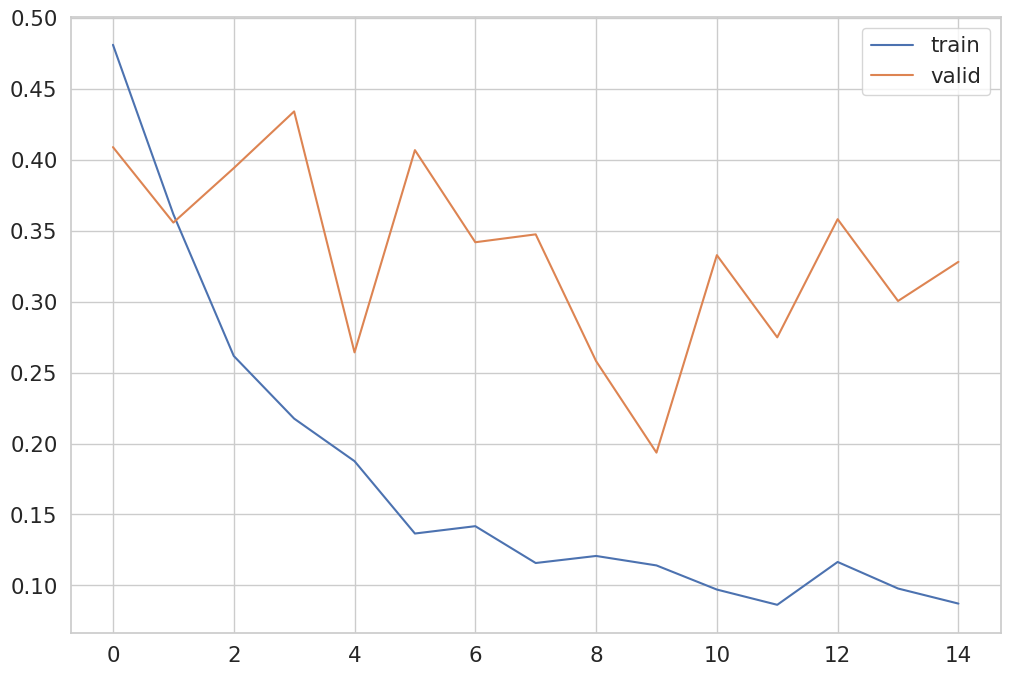

Accuracy: 0.7297


In [ ]:
plot_graph_show_acc(losses, model_VGG_extractor_1)

In [ ]:
show_test_acc(model_VGG_extractor_1)

Accuracy: 0.7935


* **С заморозкой  2/3 FE, свой классификатор (Feature Extractor)** способ:

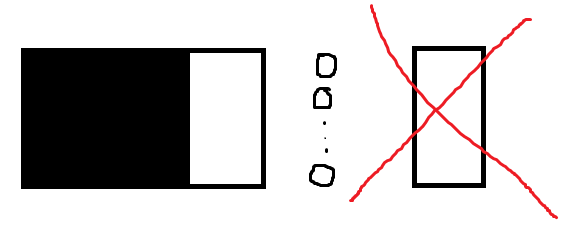

In [ ]:
model_VGG_extractor_2 = models.vgg16(pretrained=True)

In [ ]:
# замораживаем параметры (веса)
for param in model_VGG_extractor_2.features[:23+1].parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_VGG_extractor_2.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    model_VGG_extractor_2 = model_VGG_extractor_2.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только незамороженные слои
optimizer = optim.Adam(list(model_VGG_extractor_2.features.parameters())[23+1:] + 
                       list(model_VGG_extractor_2.classifier.parameters()), lr=1e-4)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
model_VGG_extractor_2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in model_VGG_extractor_2.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 7305225


In [ ]:
%%time
model_VGG_extractor_2, losses = train_model(model_VGG_extractor_2, loss_fn, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

Training complete in 1m 52s
Best val Acc: 0.689189
CPU times: user 31.3 s, sys: 4.25 s, total: 35.6 s
Wall time: 1min 52s


Нарисуем график функции потерь и вычислим точность

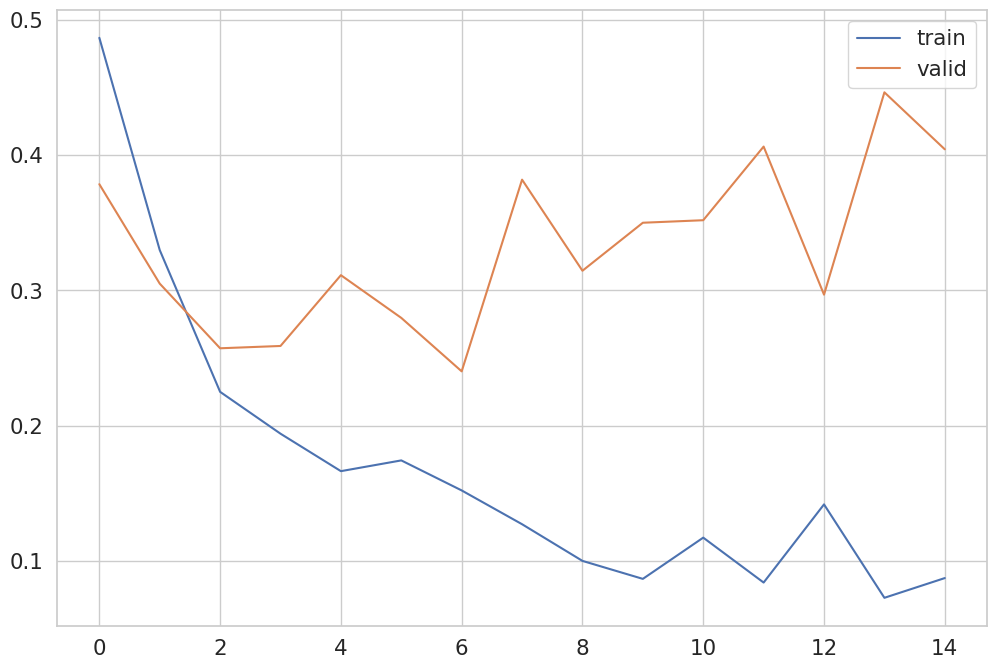

Accuracy: 0.5811


In [ ]:
plot_graph_show_acc(losses, model_VGG_extractor_2)

In [ ]:
show_test_acc(model_VGG_extractor_2)

Accuracy: 0.7609


* **С заморозкой  3/3 FE, свой классификатор (Feature Extractor)** способ:

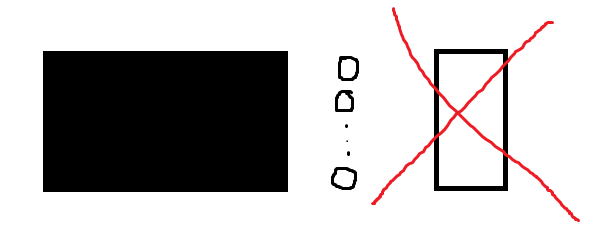

In [ ]:
model_VGG_extractor_3 = models.vgg16(pretrained=True)

сначала замораживаем Feature Extractor и обучаем только Head...

In [ ]:
# замораживаем параметры (веса)
for param in model_VGG_extractor_3.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_VGG_extractor_3.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    model_VGG_extractor_3 = model_VGG_extractor_3.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.Adam(model_VGG_extractor_3.classifier.parameters(), lr=1e-4)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in model_VGG_extractor_3.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 225801


In [ ]:
%%time
model_VGG_extractor_3,losses = train_model(model_VGG_extractor_3, loss_fn, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

Training complete in 1m 50s
Best val Acc: 0.662162
CPU times: user 29.1 s, sys: 4.3 s, total: 33.4 s
Wall time: 1min 49s


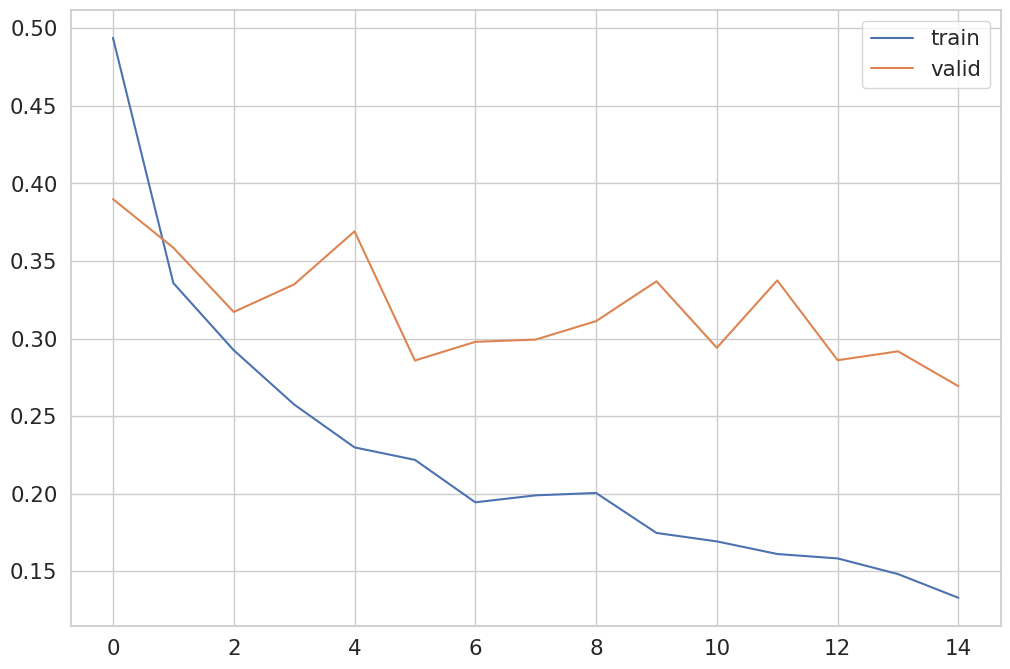

Accuracy: 0.6486


In [ ]:
plot_graph_show_acc(losses, model_VGG_extractor_3)

In [ ]:
show_test_acc(model_VGG_extractor_3)

Accuracy: 0.6957


ResNet-34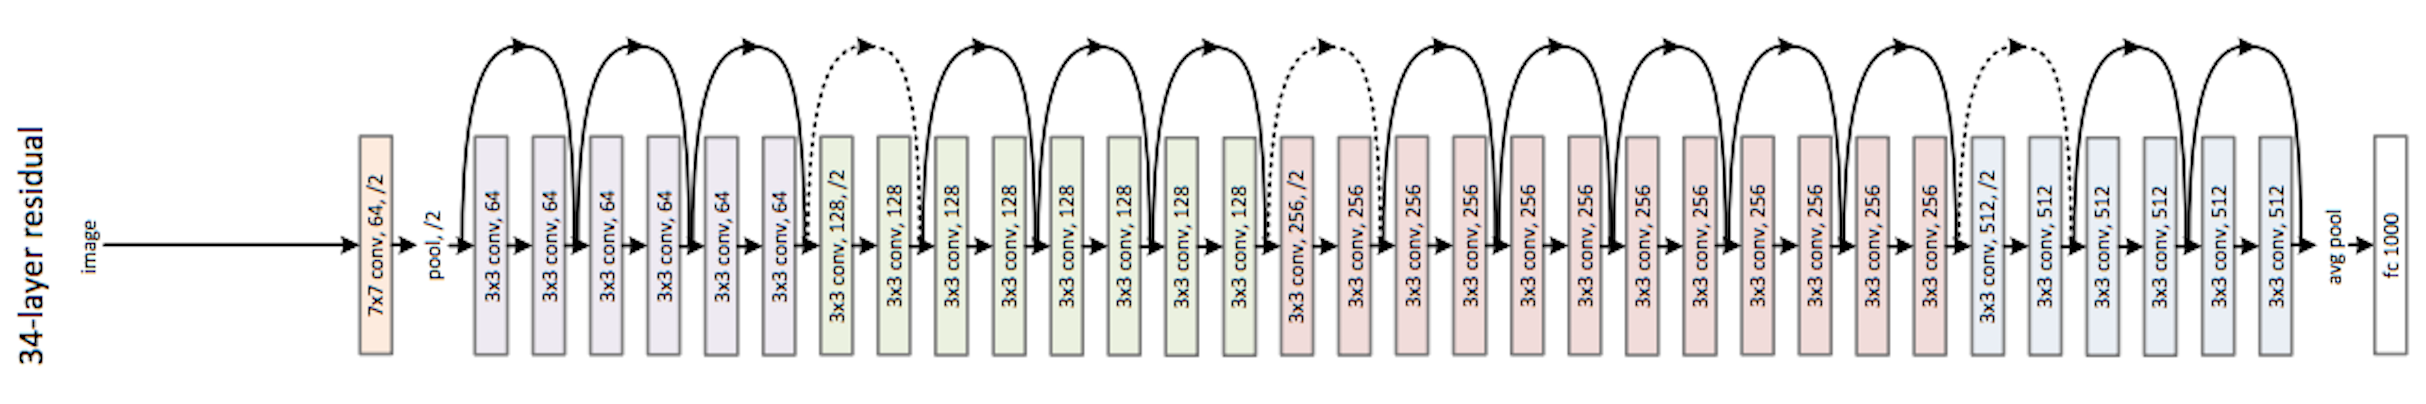

In [ ]:
from torchvision import models
model_RESNET = models.resnet34(pretrained=True)
resnet_layers = [model_RESNET.layer1, model_RESNET.layer2, model_RESNET.layer3, model_RESNET.layer4]
model_RESNET;

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:05<00:00, 16.3MB/s]


In [ ]:
model_RESNET

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in model_RESNET.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 21797672


* **Без заморозки весов, всю сеть, свой классификатор (Fine Tuning)** способ

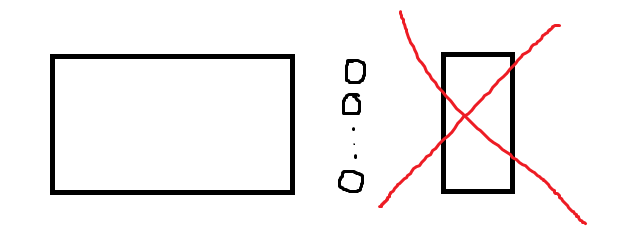

Сконфигурируем - изменим FC-слой и зададим *cost function* и *оптимизирующий алгоритм*:

(*по умолчанию backpropagation распространяется на все слои, поэтому здесь мы только заменяем FC-слой на свой классификатор*)

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
model_RESNET.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    model_RESNET = model_RESNET.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - Adam
optimizer_ft = optim.Adam(model_RESNET.parameters(), lr=1e-4)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in model_RESNET.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 21802289


In [ ]:
model_RESNET, losses = train_model(model_RESNET, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=15)

Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

Training complete in 1m 57s
Best val Acc: 0.797297


Нарисуем график функции потерь и вычислим точность

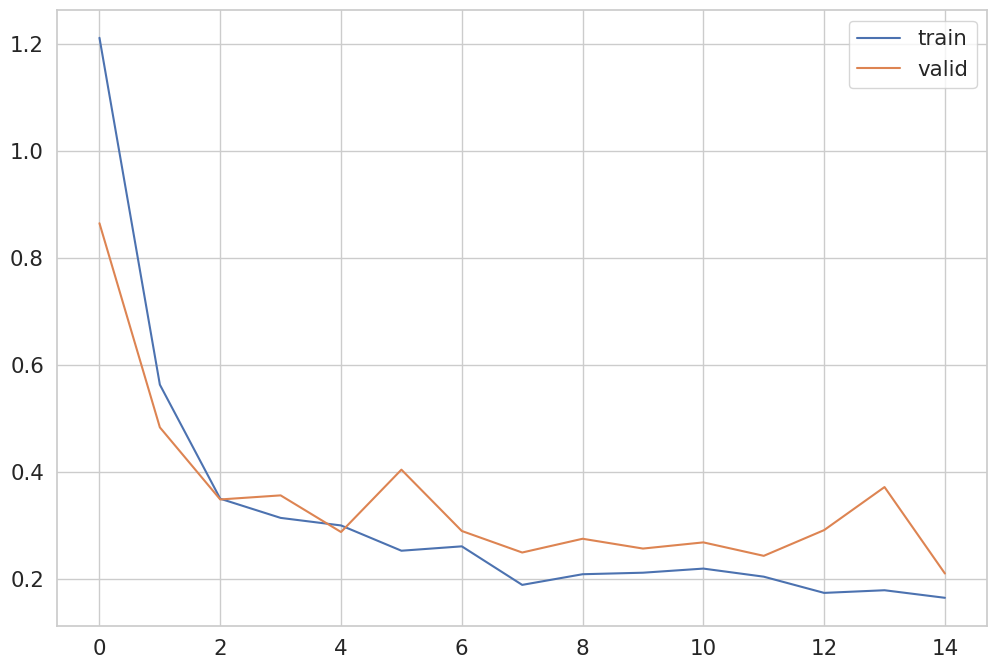

Accuracy: 0.7973


In [ ]:
plot_graph_show_acc(losses, model_RESNET)

In [ ]:
show_test_acc(model_RESNET)

Accuracy: 0.8043


* **С заморозкой  1/3 FE, свой классификатор (Feature Extractor)** способ:

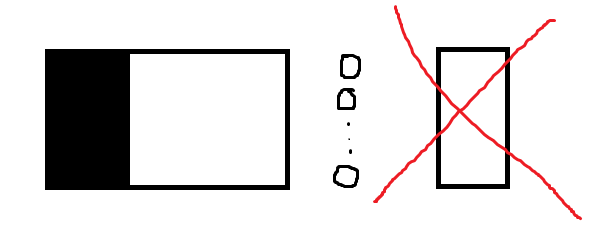

In [ ]:
model_RESNET_extractor_1 = models.resnet34(pretrained=True)

Сделаем так, чтобы на них *не распространялся backpropagation* (заморозим их), и подменим классификатор (ведь старый уже с весами для ImageNet'а).

In [ ]:
# замораживаем параметры (веса)
cap = 40
for param in model_RESNET_extractor_1.parameters():
  if cap != 0:
    param.requires_grad = False 
    cap -= 1

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
model_RESNET_extractor_1.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    model_RESNET_extractor_1 = model_RESNET_extractor_1.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только незамороженные слои
optimizer = optim.Adam(list(model_RESNET_extractor_1.parameters())[cap:] + 
                       list(model_RESNET_extractor_1.classifier.parameters()), lr=1e-4)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torch/optim/adam.py:33: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super().__init__(params, defaults)


In [ ]:
for param in model_RESNET_extractor_1.parameters():
  print(int(param.requires_grad), end = ' ')

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in model_RESNET_extractor_1.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 20750065


In [ ]:
%%time
model_RESNET_extractor_1,losses = train_model(model_RESNET_extractor_1, loss_fn, optimizer, exp_lr_scheduler, num_epochs=16)

Epoch::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

Training complete in 2m 2s
Best val Acc: 0.770270
CPU times: user 36.4 s, sys: 4.66 s, total: 41 s
Wall time: 2min 1s


Нарисуем график функции потерь и вычислим точность

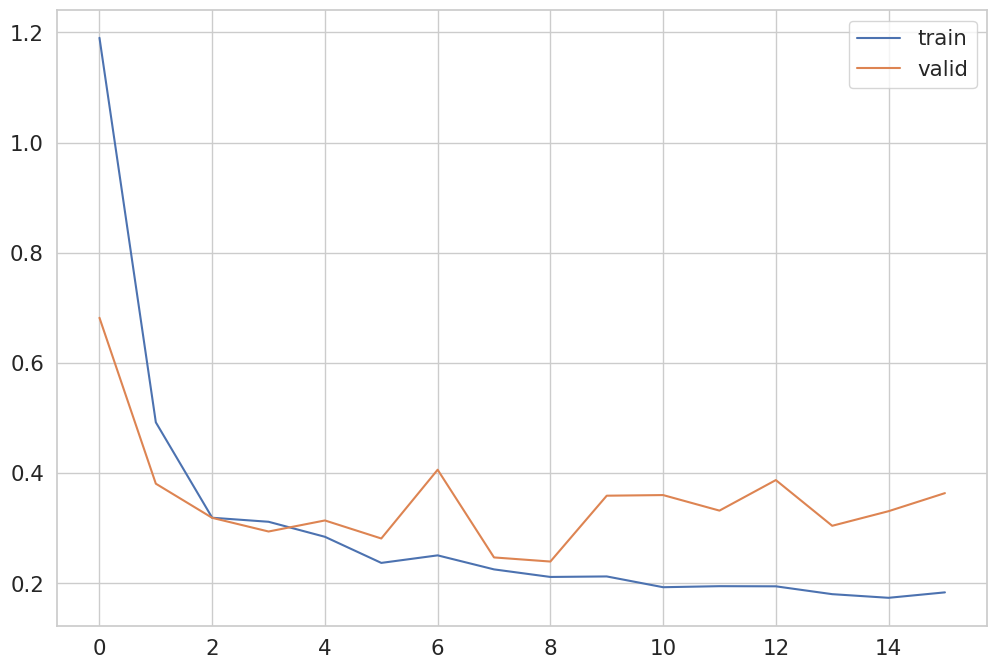

Accuracy: 0.6892


In [ ]:
plot_graph_show_acc(losses, model_RESNET_extractor_1)

In [ ]:
show_test_acc(model_RESNET_extractor_1)

Accuracy: 0.7391


* **С заморозкой  2/3 FE, свой классификатор (Feature Extractor)** способ:

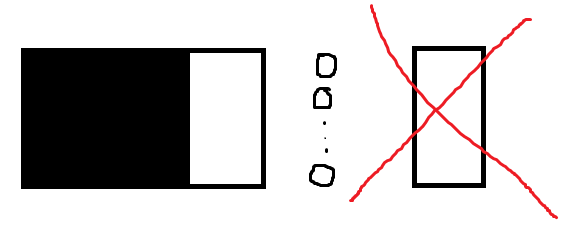

In [ ]:
model_RESNET_extractor_2 = models.resnet34(pretrained=True)

In [ ]:
# замораживаем параметры (веса)
cap = 80
for param in model_RESNET_extractor_2.parameters():
  if cap != 0:
    param.requires_grad = False 
    cap -= 1

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
model_RESNET_extractor_2.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    model_RESNET_extractor_2 = model_RESNET_extractor_2.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только незамороженные слои
optimizer = optim.Adam(list(model_RESNET_extractor_2.parameters())[cap:] + 
                       list(model_RESNET_extractor_2.classifier.parameters()), lr=1e-4)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in model_RESNET_extractor_2.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 14812913


In [ ]:
%%time
model_RESNET_extractor_2, losses = train_model(model_RESNET_extractor_2, loss_fn, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

Training complete in 1m 51s
Best val Acc: 0.770270
CPU times: user 28.5 s, sys: 4.31 s, total: 32.8 s
Wall time: 1min 50s


Нарисуем график функции потерь и вычислим точность

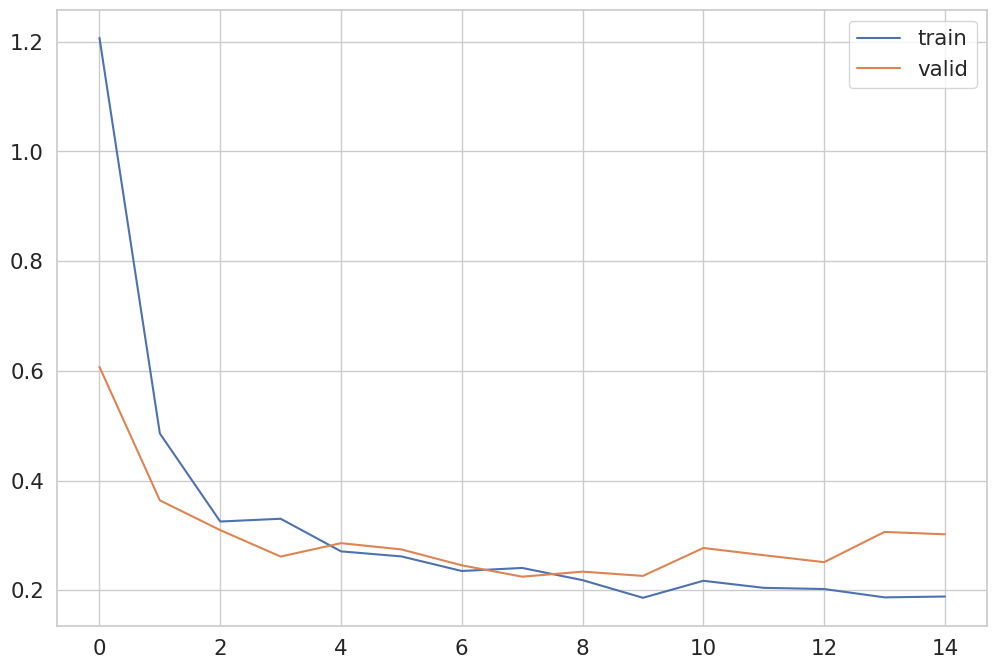

Accuracy: 0.6892


In [ ]:
plot_graph_show_acc(losses, model_RESNET_extractor_2)

In [ ]:
show_test_acc(model_RESNET_extractor_2)

Accuracy: 0.6522


* **С заморозкой  3/3 FE, свой классификатор (Feature Extractor)** способ:

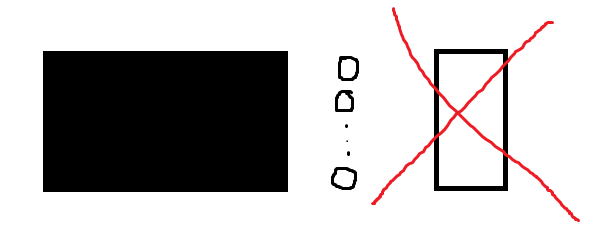

In [ ]:
from torchvision import models
model_RESNET_extractor_3 = models.resnet34(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:05<00:00, 16.2MB/s]


In [ ]:
# замораживаем параметры (веса)
for param in model_VGG_extractor_3.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_VGG_extractor_3.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    model_VGG_extractor_3 = model_VGG_extractor_3.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.Adam(model_VGG_extractor_3.classifier.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
# замораживаем параметры (веса)
for param in model_RESNET_extractor_3.parameters():
    param.requires_grad = False 

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
model_RESNET_extractor_3.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    model_RESNET_extractor_3 = model_RESNET_extractor_3.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только незамороженные слои
optimizer = optim.Adam(model_RESNET_extractor_3.classifier.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in model_RESNET_extractor_3.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 4617


In [ ]:
%%time
model_RESNET_extractor_3, losses = train_model(model_RESNET_extractor_3, loss_fn, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/72 [00:00<?, ?it/s]

RuntimeError: ignored

Нарисуем график функции потерь и вычислим точность

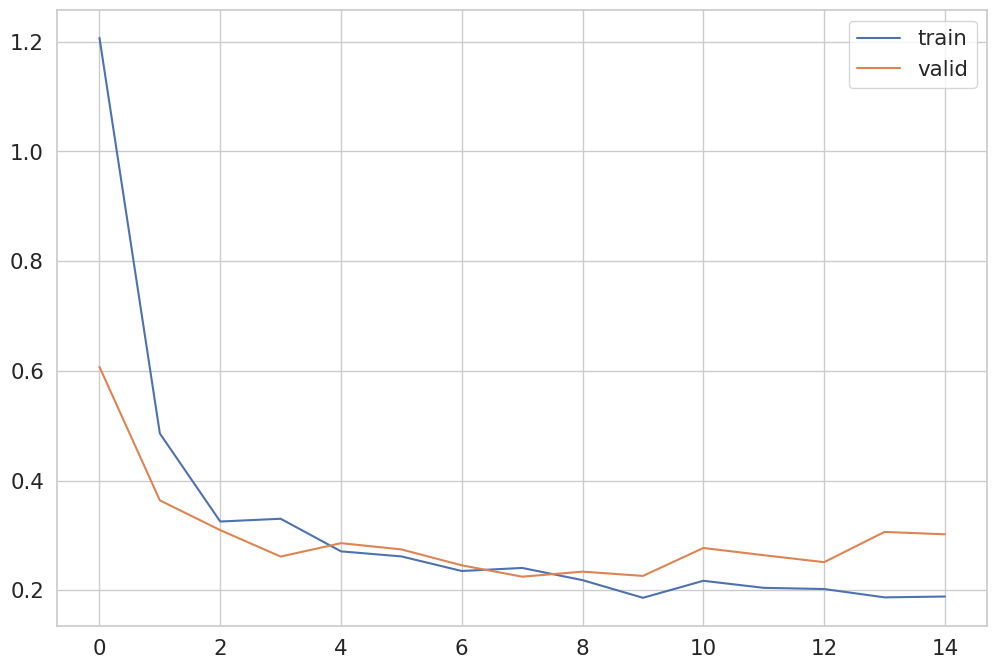

Accuracy: 0.0000


In [ ]:
plot_graph_show_acc(losses, model_RESNET_extractor_3)

In [ ]:
show_test_acc(model_RESNET_extractor_3)

Accuracy: 0.0000


## **EfficientNet B0**

* **Без заморозки весов, всю сеть, свой классификатор (Fine Tuning)** способ

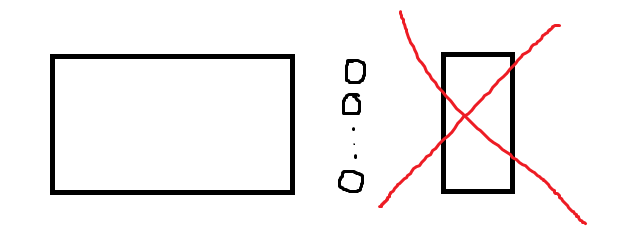

Сконфигурируем - изменим FC-слой и зададим *cost function* и *оптимизирующий алгоритм*:

(*по умолчанию backpropagation распространяется на все слои, поэтому здесь мы только заменяем FC-слой на свой классификатор*)

In [ ]:
from torchvision import models
B0 = models.efficientnet_b0(pretrained=True)
B0;

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 16.2MB/s]


In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 1280
# Заменяем Fully-Connected слой на наш линейный классификатор
B0.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    B0 = B0.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - Adam
optimizer_ft = optim.Adam(B0.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in B0.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 4019077


In [ ]:
B0, losses = train_model(B0, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=18)

Epoch::   0%|          | 0/18 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

Training complete in 2m 33s
Best val Acc: 0.824324


Нарисуем график функции потерь и вычислим точность

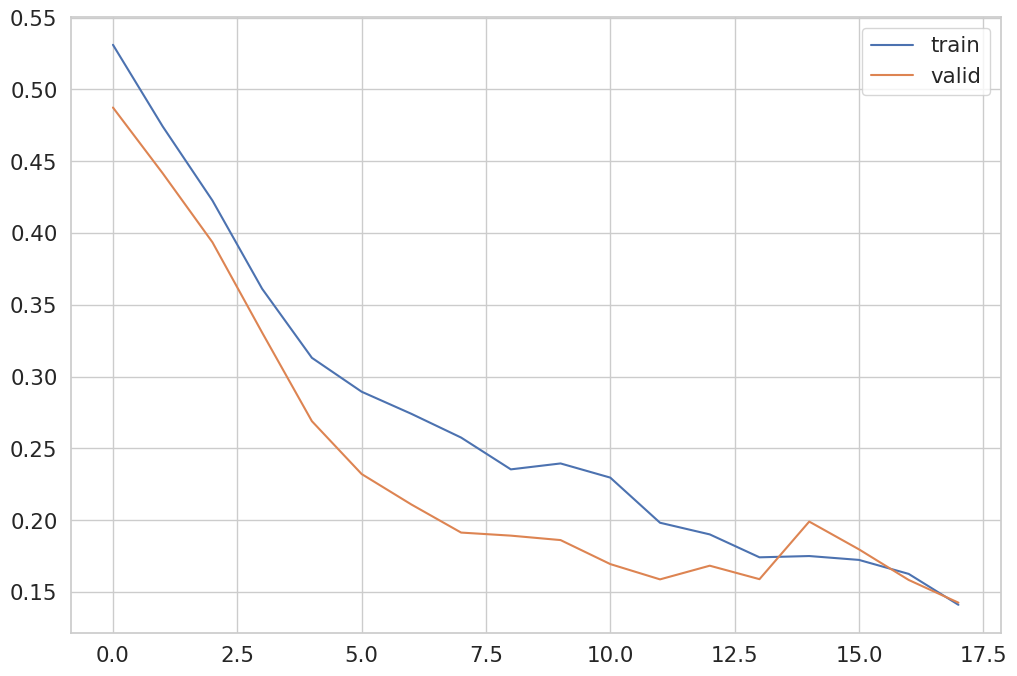

Accuracy: 0.8108


In [ ]:
plot_graph_show_acc(losses, B0)

In [ ]:
show_test_acc(B0)

Accuracy: 0.8152


## **EfficientNet B3**

In [ ]:
from torchvision import models
B3 = models.efficientnet_b3(pretrained=True)
B3

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth
100%|██████████| 47.2M/47.2M [00:03<00:00, 16.1MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 1536
# Заменяем Fully-Connected слой на наш линейный классификатор
B3.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    B3 = B3.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - Adam
optimizer_ft = optim.Adam(B3.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in B3.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 10710065


In [ ]:
B3, losses = train_model(B3, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

Training complete in 3m 18s
Best val Acc: 0.891892


Нарисуем график функции потерь и вычислим точность

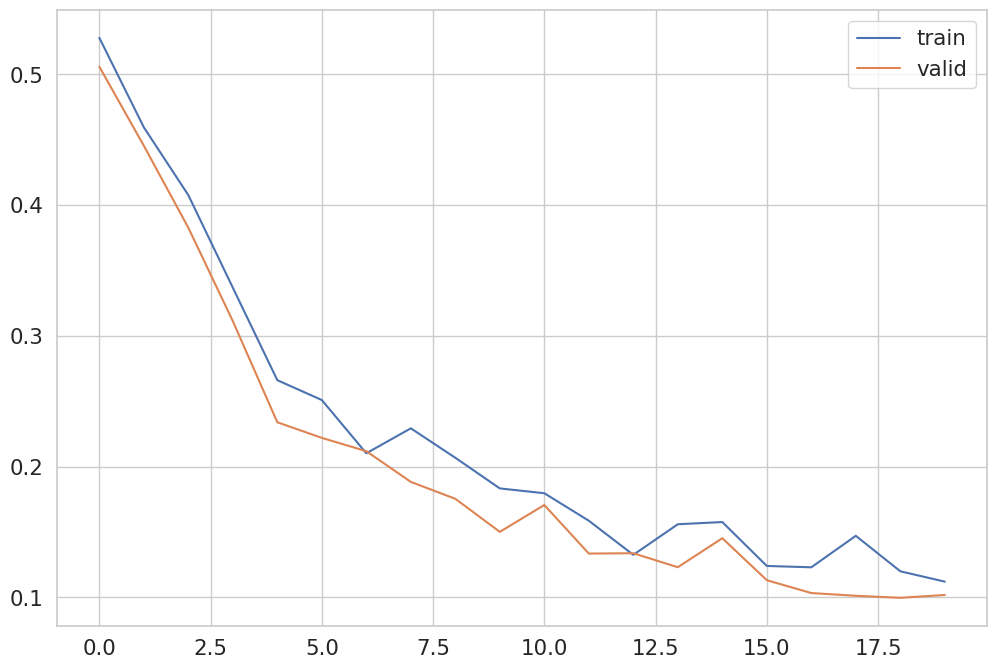

Accuracy: 0.8243


In [ ]:
plot_graph_show_acc(losses, B3)

In [ ]:
show_test_acc(B3)

Accuracy: 0.8696


## **EfficientNet B5**

In [ ]:
from torchvision import models
B5 = models.efficientnet_b5(pretrained=True)
B5

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-b6417697.pth
100%|██████████| 117M/117M [00:02<00:00, 51.4MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048
# Заменяем Fully-Connected слой на наш линейный классификатор
B5.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    B5 = B5.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - Adam
optimizer_ft = optim.Adam(B5.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in B5.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 28359225


In [ ]:
B5, losses = train_model(B5, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=18)

Epoch::   0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

Training complete in 4m 26s
Best val Acc: 0.851351


Нарисуем график функции потерь и вычислим точность

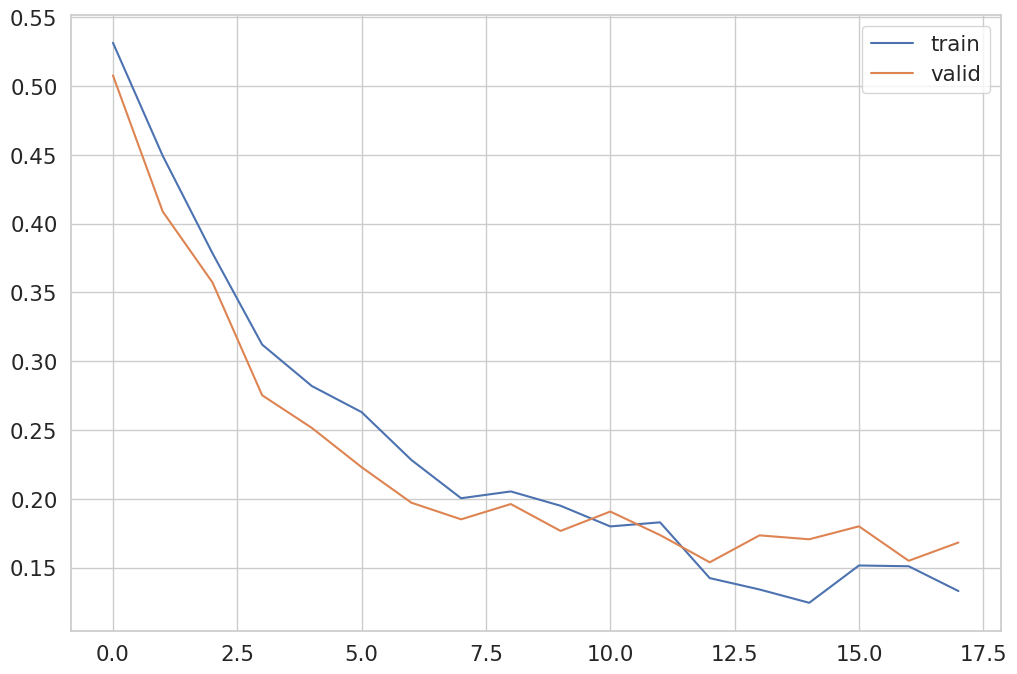

Accuracy: 0.8243


In [ ]:
plot_graph_show_acc(losses, B5)

In [ ]:
show_test_acc(B5)

Accuracy: 0.9022


## **EfficientNet B7**

In [ ]:
from torchvision import models
B7 = models.efficientnet_b7(pretrained=True)
B7

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:16<00:00, 16.2MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 2560
# Заменяем Fully-Connected слой на наш линейный классификатор
B7.classifier = nn.Linear(num_features, 9)

# Использовать ли GPU
if use_gpu:
    B7 = B7.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - Adam
optimizer_ft = optim.Adam(B7.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

In [ ]:
print("число обучаемых параметров модели:", sum(p.numel() for p in B0.parameters() if p.requires_grad)) 

число обучаемых параметров модели: 4019077


In [ ]:
B7, losses = train_model(B7, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

train iter::   0%|          | 0/72 [00:00<?, ?it/s]

valid iter::   0%|          | 0/19 [00:00<?, ?it/s]

Training complete in 6m 37s
Best val Acc: 0.891892


Нарисуем график функции потерь и вычислим точность

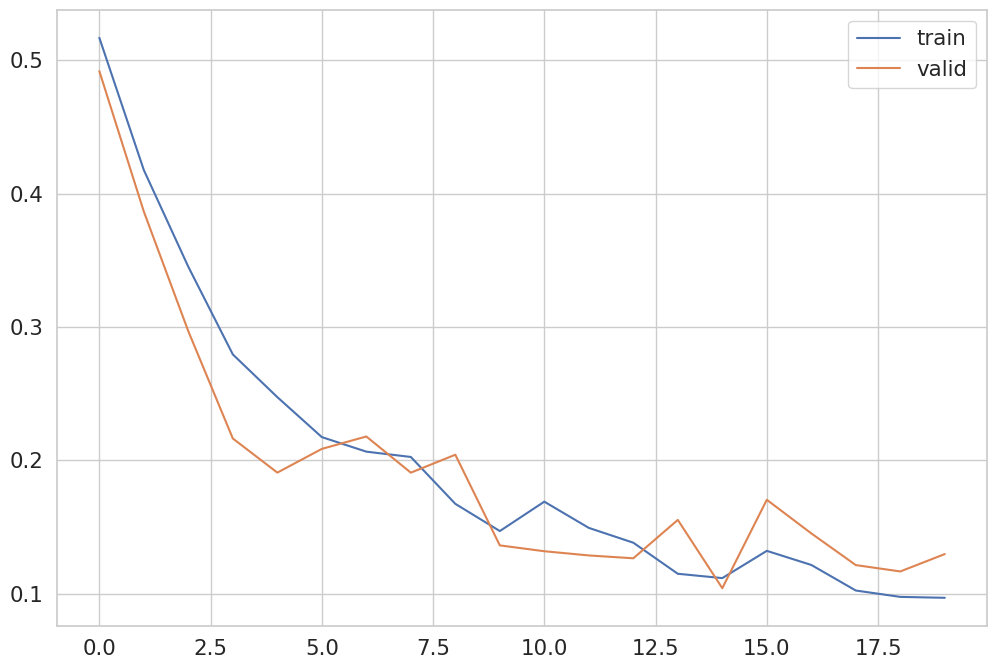

Accuracy: 0.8784


In [ ]:
plot_graph_show_acc(losses, B7)

In [ ]:
show_test_acc(B7)

Accuracy: 0.8696
